#### **GPT2 - PLAYING AROUND**

In [ ]:
from transformers import GPT2LMHeadModel

In [ ]:
model_hf = GPT2LMHeadModel.from_pretrained('gpt2')
# state_dict() will give exactly the value
sd_hf = model_hf.state_dict()

# items return (parameter, value)
sd_hf.items()
for k, v in sd_hf.items():
    print (k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [ ]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model = 'gpt2')
set_seed(42)
generator ('Chloe is cutie but Bibek is', max_length=30, num_return_sequences = 4)


### **SKELETON OF MODEL**

In [ ]:
from dataclasses import dataclass
import torch
import time
import tiktoken
import torch.nn as nn
from torch.nn import functional as F
import math
import inspect
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print (f'using device: {device}')

using device: cuda


**A transformer block** has
- A multi-head self-attention or feedforward network
- A residual connection 
- Layer normalization

**GPT-2 normalization** happends inside the residual path
* y = x * sublayer (LayerNorm(x))

In [ ]:
class CausalSelfAttention (nn.Module):
    def __init__ (self, config):
        super().__init__()
        self.c_attn = nn.Linear (config.n_embd, 3 * config.n_embd) # project input tensor to three separate vectors
        self.c_proj = nn.Linear (config.n_embd, config.n_embd) # project output back to original embedding dim
        self.c_proj.NANOGPT_SCALE_INIT = 1
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # attention mask ensuring tokens cannot attend to future tokens
        self.register_buffer ('bias', torch.tril(torch.ones(config.block_size, config.block_size)).view(1,1, config.block_size, config.block_size)) # max sequence length

    def forward (self, x):
        B,T,C = x.size() # B: batch size, T: sequence length, C: embedding size

        qkv = self.c_attn(x) # 768 -> 768*3
        q, k, v = qkv.split(self.n_embd, dim = 2) # dim = 2 means split in C (embedding size)
        k = k.view (B, T, self.n_head, C// self.n_head).transpose (1,2)
        q = q.view (B, T, self.n_head, C// self.n_head).transpose (1,2)
        v = v.view (B, T, self.n_head, C// self.n_head).transpose (1,2) 

        y = F.scaled_dot_product_attention (q,k,v, is_causal = True) #  PyTorch's built-in fast attention function
        
        y = y.transpose(1, 2).contiguous().view(B,T,C) 
        y - self.c_proj(y)
        return y



In [ ]:
class MLP (nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4* config.n_embd)
        self.gelu = nn.GELU (approximate = 'tanh')
        self.c_proj = nn.Linear (4*config.n_embd, config.n_embd)

    def forward(self, x):
        return self.c_proj(self.gelu(self.c_fc(x)))

In [ ]:
class Block (nn.Module):
    def __init__(self,config):
        super().__init__()
        self.ln_1 = nn.LayerNorm (config.n_embd)
        self.attn = CausalSelfAttention (config)
        self.ln_2 = nn.LayerNorm (config.n_embd)
        self.mlp = MLP(config)

    def forward (self, x):
        x = x + self.attn (self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

**The residual connections** in GPT-2 help prevent 'growing activation' by allowing the activations to flow more easily through the network. The addition of activations at each layer may cause their variance (or standard deviation) to grow, especially in the earlier stages of training => normalization


In [ ]:
@dataclass 
class GPTConfig:
    block_size: int = 1024  # max sequence length
    vocab_size: int = 50257 # number of tokens: 50k BPE merges + 250 bytes otkens + 1 ending
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension

class GPT(nn.Module):
    def __init__ (self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding (config.vocab_size, config.n_embd),
            wpe = nn.Embedding (config.block_size, config.n_embd),
            h = nn.ModuleList ([Block(config) for _ in range (config.n_layer)]),
            ln_f = nn.LayerNorm (config.n_embd)
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias = False)

        # tying scheme # not tie in reverse way first due to back propagation
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights) # apply function to all parameters in the model


    def _init_weights (self, module):
        if isinstance(module, nn.Linear): # check if module is a linear layer
            std = 0.02
            if hasattr (module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5 # because we have two block adding residual
            torch.nn.init.normal_(module.weight, mean = 0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias) # fill input tensor with scalar value 0
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean = 0.0, std = 0.02)


    def forward(self, idx, targets=None):
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device = idx.device) 

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = tok_emb + pos_emb
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy (logits.view(-1,logits.size(-1)), targets.view(-1))

        return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}

        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # config of gpt2 model
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]

        config_args['vocab_size'] = 50257 
        config_args['block_size'] = 1024 
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()


        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] 
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] 


        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']

        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k] = sd_hf[k].t().clone()

            else:
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
        return model


    def configure_optimizer (self, weight_decay, learning_rate, device):
        # define candidate parameters (all require grad)
        param_dict = {pn: p for pn,p in self.named_parameters()} #take para
        param_dict = {pn: p for pn,p in param_dict.items() if p.requires_grad}

        # >=2d then decay
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        no_decay_params = [p for n, p in param_dict.items() if p.dim()<2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': no_decay_params, 'weight_decay': 0.0}
        ]

        # checking the total amount weight decayed
        # num_decay_params = sum (p.numel() for p in decay_params)
        # num_nodecay_params = sum (p.numel() for p in no_decay_params)
        # print (f'total amount weight decayed: {num_decay_params}, total tensor decayed {len(decay_params)}')
        # print (f'total amount weight NO decayed (??): {num_nodecay_params}, total tensor decayed {len(no_decay_params)}')

        # fused optimization option in adam optimizer 
        # multiple small operations are combined (fused) into one big GPU operation to make things faster 
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        print (fused_available)
        use_fused = fused_available and 'cuda' in device

        print (f'using fused AdamW: {use_fused}')
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas = (0.9,0.5), eps = 1e-8, fused = use_fused)

        return optimizer

### **MAKE IT FASTER**

- TF32 is more beneficial when using GPU. The FP16 (half of FP32) has smaller range (exponent) (e5 compared to e8 in FP32). It leads to the point that when doing gradient, it can round gradient to 0. So we have to apply scaling gradient which is annoying
- Pytorch compile is magical because it reduces the overhead and memory access time *** because it compiles all things into one single object and it knows which one to run. Secondly, for example, it looks into a formula, instead of doing each part of the formula, input and ouput tranverse back and forth from GPU to memory (sth like RAM in CPU), it takes all in, processes it and transfers the output back
- GPU now have VRAM (memory) which when we fusing multiple operations into one, the amount of temporary memory required for storing intermediate results is minimized before return the final result back to the HBM
- If it causes memory error in GPT, decrease batch size to fit batch into GPU

- **Nice and ugly numbers**: mentioned by Andrej that power of 2 always generated magic number. Experiment shows it's faster to train moder than 4% (Vocb size changed to 50304)

- **HYPERPARAMETER | ADAMW | GRADIENT CLIPPING**: GPT-3 paper, use Adam with beta1 = 0.9, beta2 = 0.95, epsilon = 10^-8, clip the global norm of gradient at 1.0

**Linear learning rate warmpup**: used in training, gradually increase the learning rate from a small to target value over a few initial steps or epochs, before switching to the main learning rate schduel (cosin decay or step decay)
* lr = max_lr (want to warm up) * current_step/ warmup_steps

* Reasons vi moi dau initiate weights randomly nen model unstable. Large learning rate may lead model to diverge

**IN GPT-3 PAPER**: use cosine decay for learning rate down to 10% of its value over 260 billion tokens. Then training continues at 10% of original learning rate.
* Linear LR warm up over 375 million tokens

**weight decay**
* Set weight decay = 0.1 (we would want to apply to 2D tensor: matmuls + embeddings decay, all biases and layernorm we don't as it doesn't make sense)

* define configure_optimizers above

**fused parameter in optim.AdamW**: 3 ways of iteration
* fused: best one
* foreach: vertorized implemetation (used single batched operation across all tensors)
* for loop

In [ ]:
total_batch_size = 524288 #0.5M according to GPT-3 paper 
B= 16 
T= 1024

grad_accum_steps = total_batch_size// (B*T) #32 # accum to get 0.5M batch size

### **DATASET**

In [ ]:
pip install datasets

In [ ]:
import os
import multiprocessing as mp
import numpy as np
import tiktoken
from datasets import load_dataset
from tqdm import tqdm

In [ ]:
local_dir = 'edu_fineweb10B'
remote_name = 'sample-10BT'
shard_size = int(1e8) # 100M tokens per shard, total of 100 shards (10B tokens)

In [ ]:
# create the cache the local directory if it doesn't exist yet
DATA_CACHE_DIR = os.path.join(os.getcwd(), local_dir)
os.makedirs(DATA_CACHE_DIR, exist_ok = True)

In [ ]:
fw = load_dataset('HuggingFaceFW/fineweb-edu', name = remote_name, split = 'train')

In [ ]:
# init the tokenizer
enc = tiktoken.get_encoding('gpt2')
eot = enc._special_tokens['<|endoftext|>'] # end of text token
def tokenize(doc):
    # tokenize a single document and returns a numpy array of uint16 tokens
    tokens = [eot] # special endoftext
    tokens.extend(enc.encode_ordinary(doc['text']))
    tokens_np = np.array(tokens)
    assert (0<= tokens_np).all() and (tokens_np < 2**16).all(), 'token out of range' 
    tokens_np_uint16 = tokens_np.astype(np.uint16) 
    return tokens_np_uint16

In [ ]:
def write_datafile(filename, tokens_np):
    np.save(filename, tokens_np)

# tokenize all documents and write output shards, each of shard_size tokens (last shard has remainder)
nprocs = max(1, int(os.cpu_count()//1.2)) # define the number of cpu used
                 
with mp.Pool(nprocs) as pool:
    shard_index = 0
    all_tokens_np = np.empty((shard_size,), dtype=np.uint16)
    token_count = 0
    progress_bar = None
    for tokens in pool.imap(tokenize, fw, chunksize=16): # imap doesn't load all into memory unlike map, load all and process all at once
                          # each cpu take fw in the size of 16 item, apply function name tokenize

        # is there enough space in the current shard for the new tokens
        if token_count + len(tokens) < shard_size:
            # append tokens if available
            all_tokens_np[token_count:token_count+len(tokens)] = tokens
            token_count += len(tokens)
            # update progress bar
            if progress_bar is None:
                progress_bar = tqdm(total=shard_size, unit="tokens", desc=f"Shard {shard_index}")
            progress_bar.update(len(tokens))
        else:
            # write the current shard and start a new one
            split = "val" if shard_index == 0 else "train"
            filename = os.path.join(DATA_CACHE_DIR, f"edufineweb_{split}_{shard_index:06d}")
            # split the document into whatever fits in this shard; the remainder goes to next one
            remainder = shard_size - token_count
            progress_bar.update(remainder)
            all_tokens_np[token_count:token_count+remainder] = tokens[:remainder]
            write_datafile(filename, all_tokens_np)
            shard_index += 1
            progress_bar = None
            # put the remainder to the next shard 
            token_count = len(tokens)-remainder

    # write any remaining tokens as the last shard
    if token_count != 0:
        split = "val" if shard_index == 0 else "train"
        filename = os.path.join(DATA_CACHE_DIR, f"edufineweb_{split}_{shard_index:06d}")
        write_datafile(filename, all_tokens_np[:token_count])

In [ ]:
# load the shards and categorize them into separate batches
def load_tokes(filename):
    # load a single shard
    npt = np.load(filename)
    ptt = torch.tensor (npt, dtype=torch.long) # convert to long tensor
    return ptt

class DataLoaderLite:
    def __init__ (self, B, T, split): # split = train or val up to whether you're training or testing
        self.B = B
        self.T = T
        assert split in {'train', 'val'}

        # load the shards for this process
        data_root = 'fineweb10B'
        shards = os.listdir (data_root)
        shards = [s for s in shards if split in s] 
        shards = sorted(shards)
        shards = [os.path.join(data_root, s) for s in shards]
        self.shards = shards
        # shuffle the shards for this process

        self.current_shard = 0
        self.tokens = load_tokes(self.shards[self.current_shard])
        self.current_position = self.B * self.T

    def next_batch(self):
        B,T = self.B, self.T
        buf = self.tokens[self.current_position:self.current_position+B*T+1]
        self.x = (buf[:-1]).view(B,T)
        self.y = (buf[1:]).view(B,T)
        self.current_position += B*T
        if self.current_position + (B*T +1) > len(self.tokens):
            self.current_shard = (self.current_shard + 1) % len(self.shards)
            self.tokens = load_tokes(self.shards[self.current_shard])
            self.current_position = B * T
        return self.x, self.y

### **Training and Valuation**

In [ ]:
max_lr = 6e-4
min_lr = max_lr*0.1
warmup_steps = 715
max_steps = 19073
def get_lr (it):
    # warmp up step
    if it < warmup_steps:
        return max_lr * ((it +1)/warmup_steps)
    # training at 10% of wanted learning rate
    if it > max_steps:
        return min_lr
    # cosine decay down to min learning rate smoothly using cosine
    # start current step first after warmpup steps
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <=1, 'check decay_ratio'
    coeff = 0.5 * (1.0 + math.cos(math.pi*decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

In [ ]:
# save checkpoint as google colab runtime is soooooo unstable (or my internet is unstable)
def save_checkpoint(model, optimizer, step, loss, filename='checkpoint.pth', save_dir='/content/drive/MyDrive/checkpoints/checkpoint.pth'):
  os.makedirs(save_dir, exist_ok=True)  # create folder if it doesn't exist
  checkpoint = {
      'step': step,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss.item() if isinstance(loss, torch.Tensor) else loss,
  }
  save_path = os.path.join(save_dir, filename)
  torch.save(checkpoint, save_path)
  print(f"Checkpoint saved to: {save_path}")

In [ ]:
train_loader = DataLoaderLite(B=16, T=1024, split ='train')

### **EVALUATION**

In [ ]:
# create var_loader and train_loader
var_loader = DataLoaderLite (B = B, T=T, split = 'val')
train_loader = DataLoaderLite (B = B, T=T, split = 'train')

In [ ]:
train_loss_track = []
test_loss_track = []

torch.set_float32_matmul_precision('high')


model = GPT(GPTConfig(vocab_size = 50304))
model.to(device)
model = torch.compile(model) 

# weight decay here
optimizer = model.configure_optimizer(weight_decay=0.1, learning_rate=6e-4, device='cuda')

# evaluation step
for step in range (max_steps):
    t0 = time.time()
    if step % 100 == 0:
        # evaluation step (every 100 steps
        model.eval()
        var_loader.reset()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 20
            for _ in range (val_loss_steps):
                x,y = var_loader.next_batch()
                x,y = x.to(device), y.to(device)
                with torch.autocast (device_type = device, dtype = torch.bfloat16):
                    logits, loss = model (x,y)
                loss = loss/val_loss_steps
                val_loss_accum += loss.detach()

            print (f'validation loss {val_loss_accum.item()} at step {step}')
            test_loss_track.append(val_loss_accum.item())


    #training step (train every step)
    model.train()
    loss_accum = 0.0
    for micro_step in range (grad_accum_steps):
        x, y = train_loader.next_batch()

        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.autocast (device_type = device, dtype = torch.bfloat16):
                logits, loss = model (x,y)
        loss = loss / grad_accum_steps
        loss_accum += loss.detach()
        loss.backward()
    norm = torch.nn.utils.clip_grad_norm_ (model.parameters(), 1.0)
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    optimizer.step()

    t1 = time.time()
    dt = (t1 - t0) * 1000 

    train_loss_track.append(loss_accum.item())


    if (step != 0) and ((step+1) % 100 == 0):  # Save every 100 steps
        save_checkpoint(model, optimizer, step, loss_accum, filename=f"checkpoint_step_{step}.pth")
    torch.cuda.synchronize()

    print (f'step {step} loss is {loss_accum.item()}, norm: {norm:.4f}, learning rate {lr}, dt: {dt:.2f}ms, token per second {train_loader.B * train_loader.T / (t1 - t0)}')

In [ ]:
# save loss track in test and train process 
import pickle

with open('/content/drive/MyDrive/test_loss_track.pkl', 'wb') as f:
    pickle.dump(test_loss_track, f)

with open('/content/drive/MyDrive/train_loss_track.pkl', 'wb') as f:
    pickle.dump(train_loss_track, f)

save_path = "/content/drive/MyDrive/models/gpt_model_weights.pth"
torch.save(model.state_dict(), save_path)

In [ ]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')
model.eval()

num_return_sequences = 4
max_length = 32
tokens = enc.encode ('hello, I am a language model')
tokens = torch.tensor (tokens, dtype = torch.long)
tokens = tokens.unsqueeze(0).repeat (num_return_sequences, 1)
xgen = tokens.to(device)
sample_rng = torch.Generator (device = device) # anh keu cai nay giup minh take control duoc qua trinh sampling
sample_rng.manual_seed (42)
while xgen.size(1) < max_length:
    with torch.no_grad():
        logits, loss = model(xgen)
        logits = logits [:,-1,:]
        probs = F.softmax (logits, dim=-1)
        topk_prob, topk_indices = torch.topk (probs, 50, dim=-1)
        ix = torch.multinomial (topk_prob, 1, generator = sample_rng)
        xcol = torch.gather (topk_indices, -1, ix)
        xgen = torch.cat((xgen, xcol), dim=1)
for i in range (num_return_sequences):
  tokens = xgen [i, :max_length].tolist()
  decoded = enc.decode (tokens)
  print (f'sample {i}: {decoded}')

sample 0: hello, I am a language model engineer and educator.
My own teaching profession may be built in partnership with teachers, students, students, teachers, community members
sample 1: hello, I am a language model; that is, it is an age-related social event that affects cultural development, social mobility and identity.
A human
sample 2: hello, I am a language model. I cannot give out to ‘the mind’ that ‘the mind is a ‘self-perpet
sample 3: hello, I am a language model artist!
What is the most successful artist this year?
Why would anyone who can learn to make the right choices?


### LOSS VISUALIZATION

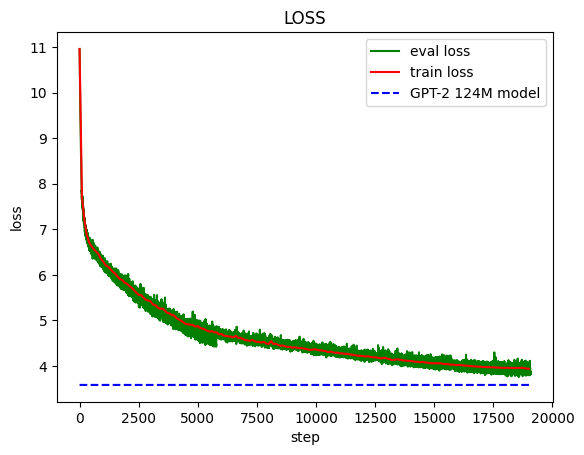

In [31]:
import matplotlib.pyplot as plt
import numpy as np

loss_value = 3.58
steps = np.arange(0, max_steps)
losses = np.full_like(steps, loss_value, dtype=float)

max_steps = 19073
plt.plot (range(0,max_steps), train_loss_track, color = 'green', label = 'eval loss')
plt.plot (range(0,max_steps,100), test_loss_track, color = 'red', label = 'train loss')
plt.plot (range(0,max_steps), losses, color = 'blue', label = 'GPT-2 124M model', linestyle='dashed')
plt.xlabel ('step')
plt.ylabel ('loss')
plt.title ('LOSS')
plt.legend()
plt.show()

### **UTILS**

In [ ]:
# Upload file to drive instead of storing in local computer
import shutil

from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/fineweb'
os.makedirs(folder_path, exist_ok=True)

colab_folder = '/content'+ "/edu_fineweb10B/"  # or wherever they are

# Loop over all .npy files
for filename in os.listdir(colab_folder):
    if filename.endswith('.npy'):
        src_path = os.path.join(colab_folder, filename)
        dst_path = os.path.join(folder_path, filename)
        shutil.move(src_path, dst_path)
        print(f"Moved: {filename} to Google Drive")



In [ ]:
# Upload file from drive
folder_path = '/content/drive/My Drive/fineweb'
def load_tokes(filename):
    # load a single shard
    npt = np.load(filename)
    ptt = torch.tensor (npt, dtype=torch.long) 
    return ptt
train_loader = DataLoaderLite(B=16, T=1024, split ='train')

In [ ]:
# Checkpoint loading and checking

checkpoint = torch.load('link_to_your_checkpoint')

for i,v in checkpoint['model_state_dict'].items():
  print (i, len(v))

state_dict = checkpoint['model_state_dict']
new_state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()} # remove _orig_mod. from keys to load checkpoint's model state dict to our org model
# it happens as we use 'compile' mode 

model = GPT(GPTConfig(vocab_size=50304))
model.to(device)
model.load_state_dict(state_dict)